Training LSTM: 100%|██████████| 40/40 [00:15<00:00,  2.51it/s]


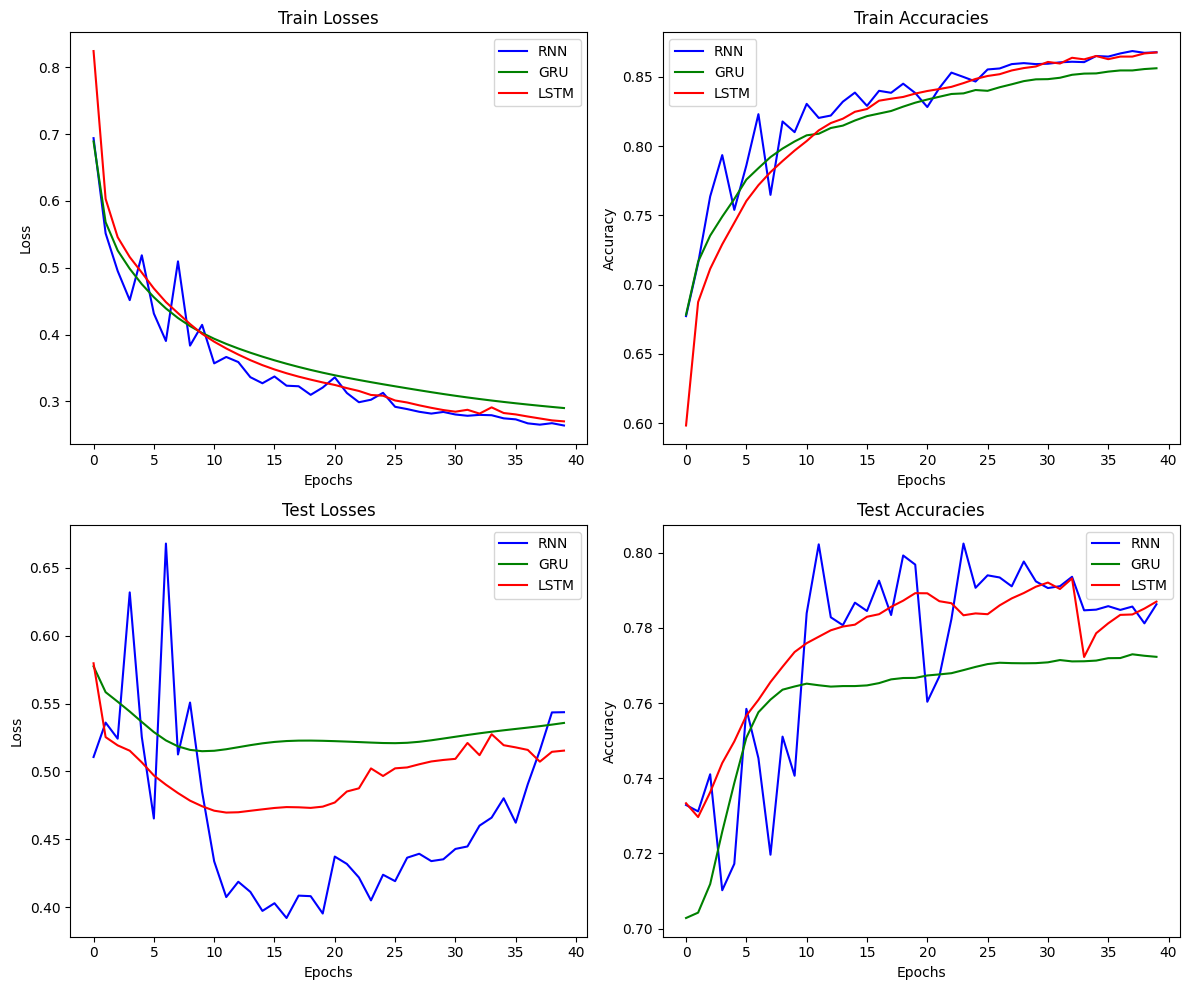


Model Comparison:
Model      Train Loss   Test Loss    Train Acc    Test Acc    
--------------------------------------------------
RNN        0.2641       0.5436       0.8678       0.7863      
GRU        0.2902       0.5357       0.8562       0.7723      
LSTM       0.2702       0.5154       0.8676       0.7870      

Best model based on test accuracy: LSTM (0.7870)


In [12]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from ucimlrepo import fetch_ucirepo
from IPython.display import clear_output
from category_encoders import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

NUM_CLASSES = 3
HIDDEN_SIZE = 32
NUM_EPOCHS = 40
BATCH_SIZE = 64
TEST_SIZE = 0.8
SEQUENCE_LENGTH = 5
LEARNING_RATE = 0.01
MOMENTUM = 0.9


def load_and_preprocess_data():
    steel_industry_energy_consumption = fetch_ucirepo(id=851)

    X = steel_industry_energy_consumption.data.features
    y = steel_industry_energy_consumption.data.targets
    categorical_columns = X.select_dtypes(include='object').columns
    numerical_columns = X.select_dtypes(include=np.number).columns

    y = LabelEncoder().fit_transform(np.ravel(y))

    columnTransformer = ColumnTransformer(
        transformers=[
            ('categorical', TargetEncoder(), categorical_columns),
            ('num', StandardScaler(), numerical_columns)]
    )
    X = columnTransformer.fit_transform(X, y)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=TEST_SIZE, shuffle=False)

    return X_train, X_test, y_train, y_test


class EnergyConsumptionDataset(Dataset):

    def __init__(self, X, y, seq_length=1):
        self.X = torch.tensor(X, dtype=torch.float)
        self.y = torch.tensor(y).long()
        self.seq_length = seq_length

    def __len__(self):
        return self.X.shape[0] - (self.seq_length - 1)

    def __getitem__(self, index):
        return (self.X[index:index + self.seq_length],
                self.y[index + self.seq_length - 1])


def create_data_loaders(X_train, X_test, y_train, y_test, batch_size, seq_length):

    train_loader = DataLoader(
        EnergyConsumptionDataset(X_train, y_train, seq_length),
        batch_size=batch_size,
        shuffle=False
    )

    test_loader = DataLoader(
        EnergyConsumptionDataset(X_test, y_test, seq_length),
        batch_size=batch_size,
        shuffle=False
    )

    return train_loader, test_loader


def plot_loss_acc(train_losses, test_losses, train_accuracies, test_accuracies):

    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(test_losses) + 1), test_losses, label='test')
    axs[0].set_ylabel('loss')

    axs[1].plot(range(1, len(train_accuracies) + 1), train_accuracies, label='train')
    axs[1].plot(range(1, len(test_accuracies) + 1), test_accuracies, label='test')
    axs[1].set_ylabel('accuracy')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    plt.show()


class RNNClassifier(nn.Module):
    def __init__(self, in_features, num_classes, hidden_size):
        super().__init__()
        self.encoder = nn.RNN(
            input_size=in_features,
            hidden_size=hidden_size,
            batch_first=True,
            nonlinearity='relu'
        )
        self.classifier = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        _, out = self.encoder(x)
        return self.classifier(out[-1])


class LSTMClassifier(nn.Module):
    def __init__(self, in_features, num_classes, hidden_size):
        super().__init__()
        self.encoder = nn.LSTM(
            input_size=in_features,
            hidden_size=hidden_size,
            batch_first=True
        )
        self.classifier = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        _, (hn, _) = self.encoder(x)
        return self.classifier(hn[-1])


class GRUClassifier(nn.Module):
    def __init__(self, in_features, num_classes, hidden_size):
        super().__init__()
        self.encoder = nn.GRU(
            input_size=in_features,
            hidden_size=hidden_size,
            batch_first=True
        )
        self.classifier = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        _, out = self.encoder(x)
        return self.classifier(out[-1])


def train_model(model, train_loader, test_loader, model_name, num_epochs=NUM_EPOCHS):
    optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
    criterion = nn.CrossEntropyLoss()

    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []

    for epoch in tqdm(range(1, num_epochs + 1), desc=f"Training {model_name}"):
        model.train()
        train_loss, train_accuracy = 0.0, 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * X_batch.shape[0]
            train_accuracy += (predictions.argmax(axis=1) == y_batch).sum().item()

        model.eval()
        test_loss, test_accuracy = 0.0, 0.0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                predictions = model(X_batch)
                loss = criterion(predictions, y_batch)
                test_loss += loss.item() * X_batch.shape[0]
                test_accuracy += (predictions.argmax(axis=1) == y_batch).sum().item()

        train_loss /= len(train_loader.dataset)
        test_loss /= len(test_loader.dataset)
        train_accuracy /= len(train_loader.dataset)
        test_accuracy /= len(test_loader.dataset)

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)

    return {
        'train_losses': train_losses,
        'test_losses': test_losses,
        'train_accuracies': train_accuracies,
        'test_accuracies': test_accuracies
    }


def plot_comparison(results):
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    axes[0, 0].plot(results['RNN']['train_losses'], label='RNN', color='blue')
    axes[0, 0].plot(results['GRU']['train_losses'], label='GRU', color='green')
    axes[0, 0].plot(results['LSTM']['train_losses'], label='LSTM', color='red')
    axes[0, 0].set_title('Train Losses')
    axes[0, 0].set_xlabel('Epochs')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()

    axes[0, 1].plot(results['RNN']['train_accuracies'], label='RNN', color='blue')
    axes[0, 1].plot(results['GRU']['train_accuracies'], label='GRU', color='green')
    axes[0, 1].plot(results['LSTM']['train_accuracies'], label='LSTM', color='red')
    axes[0, 1].set_title('Train Accuracies')
    axes[0, 1].set_xlabel('Epochs')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()

    axes[1, 0].plot(results['RNN']['test_losses'], label='RNN', color='blue')
    axes[1, 0].plot(results['GRU']['test_losses'], label='GRU', color='green')
    axes[1, 0].plot(results['LSTM']['test_losses'], label='LSTM', color='red')
    axes[1, 0].set_title('Test Losses')
    axes[1, 0].set_xlabel('Epochs')
    axes[1, 0].set_ylabel('Loss')
    axes[1, 0].legend()

    axes[1, 1].plot(results['RNN']['test_accuracies'], label='RNN', color='blue')
    axes[1, 1].plot(results['GRU']['test_accuracies'], label='GRU', color='green')
    axes[1, 1].plot(results['LSTM']['test_accuracies'], label='LSTM', color='red')
    axes[1, 1].set_title('Test Accuracies')
    axes[1, 1].set_xlabel('Epochs')
    axes[1, 1].set_ylabel('Accuracy')
    axes[1, 1].legend()

    plt.tight_layout()
    plt.show()


def print_comparison_table(results):
    print("\nModel Comparison:")
    print(f"{'Model':<10} {'Train Loss':<12} {'Test Loss':<12} {'Train Acc':<12} {'Test Acc':<12}")
    print("-" * 50)

    for model_name in ['RNN', 'GRU', 'LSTM']:
        metrics = results[model_name]
        print(f"{model_name:<10} "
              f"{metrics['train_losses'][-1]:<12.4f} "
              f"{metrics['test_losses'][-1]:<12.4f} "
              f"{metrics['train_accuracies'][-1]:<12.4f} "
              f"{metrics['test_accuracies'][-1]:<12.4f}")


def find_best_model(results):
    final_test_accuracies = {
        model_name: metrics['test_accuracies'][-1]
        for model_name, metrics in results.items()
    }

    best_model = max(final_test_accuracies, key=final_test_accuracies.get)
    print(f"\nBest model based on test accuracy: {best_model} "
          f"({final_test_accuracies[best_model]:.4f})")
    return best_model


def main():
    X_train, X_test, y_train, y_test = load_and_preprocess_data()

    train_loader, test_loader = create_data_loaders(
        X_train, X_test, y_train, y_test, BATCH_SIZE, SEQUENCE_LENGTH)

    input_size = X_train.shape[1]
    models = {
        'RNN': RNNClassifier(input_size, NUM_CLASSES, HIDDEN_SIZE),
        'GRU': GRUClassifier(input_size, NUM_CLASSES, HIDDEN_SIZE),
        'LSTM': LSTMClassifier(input_size, NUM_CLASSES, HIDDEN_SIZE)
    }

    results = {}
    for model_name, model in models.items():
        results[model_name] = train_model(model, train_loader, test_loader, model_name, NUM_EPOCHS)

    plot_comparison(results)

    print_comparison_table(results)

    find_best_model(results)


if __name__ == "__main__":
    main()

## Ручная реализация

In [13]:
import copy

import numpy as np
from numpy.core.multiarray import array as array
from scipy.special import expit, softmax, log_softmax


class Module():
    def __init__(self):
        self.output = None
        self.training = True

    def compute_output(self, input, *args, **kwargs):
        raise NotImplementedError

    def compute_grad_input(self, input, *args, **kwargs):
        raise NotImplementedError

    def update_grad_parameters(self, input, *args, **kwargs):
        pass

    def __call__(self, input, *args, **kwargs):
        return self.forward(input, *args, **kwargs)

    def forward(self, input, *args, **kwargs):
        self.output = self.compute_output(input, *args, **kwargs)
        return self.output

    def backward(self, input, *args, **kwargs):
        grad_input = self.compute_grad_input(input, *args, **kwargs)
        self.update_grad_parameters(input, *args, **kwargs)
        return grad_input

    def train(self):
        self.training = True

    def eval(self):
        self.training = False

    def zero_grad(self):
        pass

    def parameters(self):
        return []

    def parameters_grad(self):
        return []


class Criterion():
    def __init__(self):
        self.output = None

    def compute_output(self, input, target):
        raise NotImplementedError

    def compute_grad_input(self, input, target):
        raise NotImplementedError

    def __call__(self, input, target):
        return self.forward(input, target)

    def forward(self, input, target):
        self.output = self.compute_output(input, target)
        return self.output

    def backward(self, input, target):
        grad_input = self.compute_grad_input(input, target)
        return grad_input


class Optimizer():
    def __init__(self, module: Module):
        self.module = module
        self.state = {}

    def zero_grad(self):
        self.module.zero_grad()

    def step(self):
        raise NotImplementedError


class ReLU(Module):
    def compute_output(self, input):
        return np.where(input > 0, input, 0)

    def compute_grad_input(self, input, grad_output):
        return grad_output * np.where(input > 0, 1, 0)


class Tanh(Module):
    def compute_output(self, input):
        return np.tanh(input)

    def compute_grad_input(self, input, grad_output):
        return grad_output * (1 - (self.compute_output(input) ** 2))


class Sigmoid(Module):
    def compute_output(self, input):
        return expit(input)

    def compute_grad_input(self, input, grad_output):
        return grad_output * self.compute_output(input) * (1 - self.compute_output(input))


class LogSoftmax(Module):
    def compute_output(self, input):
        return log_softmax(input, axis=1)

    def compute_grad_input(self, input, grad_output):
        return grad_output - (np.sum(grad_output, axis=1, keepdims=True) * softmax(input, axis=1))


class CrossEntropyLoss(Criterion):
    def __init__(self):
        super().__init__()
        self.log_softmax = LogSoftmax()

    def compute_output(self, input, target):
        return (-1 / input.shape[0]) * np.sum(
            input[np.arange(input.shape[0]), target] - np.log(np.sum(np.exp(input), axis=1)))

    def compute_grad_input(self, input, target):
        return (-1 / input.shape[0]) * (
                np.where(np.arange(input.shape[1]) == target[:, None], 1, 0) - softmax(input, axis=1))


class Linear(Module):
    def __init__(self, in_features, out_features, bias = True):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = np.random.uniform(-1, 1, (out_features, in_features)) / np.sqrt(in_features)
        self.bias = np.random.uniform(-1, 1, out_features) / np.sqrt(in_features) if bias else None

        self.grad_weight = np.zeros_like(self.weight)
        self.grad_bias = np.zeros_like(self.bias) if bias else None

    def compute_output(self, input):
        if self.bias is not None:
            return input @ self.weight.T + self.bias
        return input @ self.weight.T

    def compute_grad_input(self, input, grad_output):
        return grad_output @ self.weight

    def update_grad_parameters(self, input, grad_output):
        if self.bias is not None:
            self.grad_bias += np.sum(grad_output, axis=0)
        self.grad_weight += grad_output.T @ input

    def zero_grad(self):
        self.grad_weight.fill(0)
        if self.bias is not None:
            self.grad_bias.fill(0)

    def parameters(self):
        if self.bias is not None:
            return [self.weight, self.bias]
        return [self.weight]

    def parameters_grad(self):
        if self.bias is not None:
            return [self.grad_weight, self.grad_bias]
        return [self.grad_weight]


class SGD(Optimizer):
    def __init__(self, module: Module, lr: float = 1e-3, momentum: float = 0.0,
                 weight_decay: float = 0.0):
        super().__init__(module)
        self.lr = lr
        self.momentum = momentum
        self.weight_decay = weight_decay

    def step(self):
        parameters = self.module.parameters()
        gradients = self.module.parameters_grad()
        if 'm' not in self.state:
            self.state['m'] = [np.zeros_like(param) for param in parameters]
        for param, grad, m in zip(parameters, gradients, self.state['m']):
            g = grad + self.weight_decay * param
            np.add(self.momentum * m, g, out=m)
            np.add(param, -self.lr * m, out=param)


class RNNCell(Module):
    def __init__(self, input_size, hidden_size, bias = True, nonlinearity = 'relu'):
        super().__init__()
        self.weight_ih = np.random.uniform(-1, 1, (hidden_size, input_size)) / np.sqrt(hidden_size)
        self.weight_hh = np.random.uniform(-1, 1, (hidden_size, hidden_size)) / np.sqrt(hidden_size)
        self.bias_ih = np.random.uniform(-1, 1, hidden_size) / np.sqrt(hidden_size) if bias else None
        self.bias_hh = np.random.uniform(-1, 1, hidden_size) / np.sqrt(hidden_size) if bias else None

        self.grad_weight_ih = np.zeros_like(self.weight_ih)
        self.grad_weight_hh = np.zeros_like(self.weight_hh)
        self.grad_bias_ih = np.zeros_like(self.bias_ih)
        self.grad_bias_hh = np.zeros_like(self.bias_hh)

        self.cache = None

    def compute_output(self, input, hx):
        relu = ReLU()
        if self.bias_hh is not None:
            self.cache = input @ self.weight_ih.T + self.bias_ih + hx @ self.weight_hh.T + self.bias_hh
            return relu(self.cache)
        self.cache = input @ self.weight_ih.T + hx @ self.weight_hh.T
        return relu(self.cache)

    def compute_grad_input(self, input, hx, grad_output):
        relu = ReLU()
        ReLU_grad = relu.backward(self.cache, grad_output)
        return ReLU_grad @ self.weight_hh

    def update_grad_parameters(self, input, hx, grad_hx):
        relu = ReLU()
        ReLU_grad = relu.backward(self.cache, grad_hx)
        if self.bias_ih is not None:
            self.grad_bias_ih += np.sum(ReLU_grad, axis=0)
            self.grad_bias_hh += np.sum(ReLU_grad, axis=0)
        self.grad_weight_ih += ReLU_grad.T @ input
        self.grad_weight_hh += ReLU_grad.T @ hx

    def zero_grad(self):
        self.grad_weight_ih.fill(0)
        self.grad_weight_hh.fill(0)
        if self.bias_ih is not None:
            self.grad_bias_hh.fill(0)
            self.grad_bias_ih.fill(0)

    def parameters(self):
        if self.bias_hh is not None:
            return [self.weight_ih, self.weight_hh, self.bias_ih, self.bias_hh]
        return [self.weight_ih, self.weight_hh]

    def parameters_grad(self):
        if self.bias_hh is not None:
            return [self.grad_weight_ih, self.grad_weight_hh, self.grad_bias_ih, self.grad_bias_hh]
        return [self.grad_weight_ih, self.grad_weight_hh]


class RNN(Module):
    def __init__(self, input_size, hidden_size, bias = True, nonlinearity = 'relu'):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        self.nonlinearity = nonlinearity
        self.module = RNNCell(self.input_size, self.hidden_size, bias=self.bias, nonlinearity=nonlinearity)
        self.modules = None

        self.weight_ih_l0 = self.module.weight_ih
        self.weight_hh_l0 = self.module.weight_hh
        self.bias_ih_l0 = self.module.bias_ih if bias else None
        self.bias_hh_l0 = self.module.bias_hh if bias else None

        self.grad_weight_ih_l0 = np.zeros_like(self.weight_ih_l0)
        self.grad_weight_hh_l0 = np.zeros_like(self.weight_hh_l0)
        self.grad_bias_ih_l0 = np.zeros_like(self.bias_ih_l0)
        self.grad_bias_hh_l0 = np.zeros_like(self.bias_hh_l0)

    def compute_output(self, input, hx):
        self.modules = [copy.deepcopy(self.module) for _ in range(input.shape[1])]
        y = hx[0]
        for i in range(len(self.modules)):
            y = self.modules[i](input[:, i, :], y)
        return y

    def compute_grad_input(self, input, hx, grad_output):
        grad_input = grad_output[0]
        for i in range(len(self.modules) - 1, 0, -1):
            grad_input = self.modules[i].backward(input[:, i, :], self.modules[i - 1].output, grad_input)
        return self.modules[0].backward(input[:, 0, :], hx[0], grad_input)

    def update_grad_parameters(self, input, hx, grad_output):
        for module in self.modules:
            for rnn_grad, rnn_cell_grad in zip(self.parameters_grad(), module.parameters_grad()):
                rnn_grad += rnn_cell_grad

    def train(self):
        if self.modules is None:
            self.module.train()
            return
        for module in self.modules:
            module.train()

    def eval(self):
        if self.modules is None:
            self.module.eval()
            return
        for module in self.modules:
            module.eval()

    def zero_grad(self):
        if self.modules is None:
            self.module.zero_grad()
            return
        self.grad_weight_ih_l0.fill(0)
        self.grad_weight_hh_l0.fill(0)
        if self.bias_ih_l0 is not None:
            self.grad_bias_hh_l0.fill(0)
            self.grad_bias_ih_l0.fill(0)

    def parameters(self):
        if self.bias_hh_l0 is not None:
            return [self.weight_ih_l0, self.weight_hh_l0, self.bias_ih_l0, self.bias_hh_l0]
        return [self.weight_ih_l0, self.weight_hh_l0]

    def parameters_grad(self):
        if self.bias_hh_l0 is not None:
            return [self.grad_weight_ih_l0, self.grad_weight_hh_l0, self.grad_bias_ih_l0, self.grad_bias_hh_l0]
        return [self.grad_weight_ih_l0, self.grad_weight_hh_l0]


class LSTMCell(Module):
    def __init__(self, input_size, hidden_size, bias = True):
        super().__init__()
        self.weight_ih = np.random.uniform(-1, 1, (4 * hidden_size, input_size)) / np.sqrt(hidden_size)
        self.weight_hh = np.random.uniform(-1, 1, (4 * hidden_size, hidden_size)) / np.sqrt(hidden_size)
        self.bias_ih = np.random.uniform(-1, 1, 4 * hidden_size) / np.sqrt(hidden_size) if bias else None
        self.bias_hh = np.random.uniform(-1, 1, 4 * hidden_size) / np.sqrt(hidden_size) if bias else None
        self.hidden_size = hidden_size

        self.grad_weight_ih = np.zeros_like(self.weight_ih)
        self.grad_weight_hh = np.zeros_like(self.weight_hh)
        self.grad_bias_ih = np.zeros_like(self.bias_ih)
        self.grad_bias_hh = np.zeros_like(self.bias_hh)

        self.ifgo_grad = None
        self.input_gate = None
        self.forget_gate = None
        self.output_gate = None
        self.gain_gate = None
        self.next_cell_state = None
        self.next_hidden_state = None

    def compute_output(self, input, hx, cx):
        tanh = Tanh()
        sigmoid = Sigmoid()
        A = input @ self.weight_ih.T + hx @ self.weight_hh.T
        if self.bias_hh is not None:
            A += self.bias_ih + self.bias_hh
        self.input_gate = sigmoid(A[:, 0: self.hidden_size])
        self.forget_gate = sigmoid(A[:, self.hidden_size: 2 * self.hidden_size])
        self.gain_gate = tanh(A[:, 2 * self.hidden_size: 3 * self.hidden_size])
        self.output_gate = sigmoid(A[:, 3 * self.hidden_size: 4 * self.hidden_size])
        self.next_cell_state = self.forget_gate * cx + self.input_gate * self.gain_gate
        self.next_hidden_state = self.output_gate * tanh(self.next_cell_state)
        return self.next_hidden_state, self.next_cell_state

    def compute_grad_input(self, input, hx, cx, grad_hx,
                           grad_cx):
        tanh = Tanh()
        tanh_grad = tanh.compute_grad_input(self.next_cell_state, grad_hx * self.output_gate)

        grad_next_cell_state = (grad_cx + tanh_grad) * self.forget_gate

        grad_input_gate = (grad_cx + tanh_grad) * self.gain_gate
        grad_input_gate *= self.input_gate * (1 - self.input_gate)

        grad_forget_gate = (grad_cx + tanh_grad) * cx
        grad_forget_gate *= self.forget_gate * (1 - self.forget_gate)

        grad_output_gate = grad_hx * tanh(self.next_cell_state)
        grad_output_gate *= self.output_gate * (1 - self.output_gate)

        grad_gain_gate = (grad_cx + tanh_grad) * self.input_gate
        grad_gain_gate *= (1 - (self.gain_gate ** 2))

        self.ifgo_grad = np.concatenate([grad_input_gate, grad_forget_gate, grad_gain_gate, grad_output_gate], axis=1)
        grad_next_hidden_state = self.ifgo_grad @ self.weight_hh
        return grad_next_hidden_state, grad_next_cell_state

    def update_grad_parameters(self, input, hx, cx, grad_hx, grad_cx):
        self.grad_weight_ih += self.ifgo_grad.T @ input
        self.grad_weight_hh += self.ifgo_grad.T @ hx
        if self.bias_hh is not None:
            self.grad_bias_ih += np.sum(self.ifgo_grad, axis=0)
            self.grad_bias_hh += np.sum(self.ifgo_grad, axis=0)

    def zero_grad(self):
        self.grad_weight_ih.fill(0)
        self.grad_weight_hh.fill(0)
        if self.bias_ih is not None:
            self.grad_bias_hh.fill(0)
            self.grad_bias_ih.fill(0)

    def parameters(self):
        if self.bias_hh is not None:
            return [self.weight_ih, self.weight_hh, self.bias_ih, self.bias_hh]
        return [self.weight_ih, self.weight_hh]

    def parameters_grad(self):
        if self.bias_hh is not None:
            return [self.grad_weight_ih, self.grad_weight_hh, self.grad_bias_ih, self.grad_bias_hh]
        return [self.grad_weight_ih, self.grad_weight_hh]


class LSTM(Module):
    def __init__(self, input_size, hidden_size, bias = True):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        self.module = LSTMCell(self.input_size, self.hidden_size, bias=self.bias)
        self.modules = None

        self.weight_ih_l0 = self.module.weight_ih
        self.weight_hh_l0 = self.module.weight_hh
        self.bias_ih_l0 = self.module.bias_ih if bias else None
        self.bias_hh_l0 = self.module.bias_hh if bias else None

        self.grad_weight_ih_l0 = np.zeros_like(self.weight_ih_l0)
        self.grad_weight_hh_l0 = np.zeros_like(self.weight_hh_l0)
        self.grad_bias_ih_l0 = np.zeros_like(self.bias_ih_l0)
        self.grad_bias_hh_l0 = np.zeros_like(self.bias_hh_l0)

    def compute_output(self, input, hx, cx):
        self.modules = [copy.deepcopy(self.module) for _ in range(input.shape[1])]
        hx = hx[0]
        cx = cx[0]
        for i in range(len(self.modules)):
            hx, cx = self.modules[i](input[:, i, :], hx, cx)
        return hx, cx

    def compute_grad_input(self, input, hx, cx, grad_hx):
        grad_hx = grad_hx[0]
        grad_cx = np.zeros_like(grad_hx)
        for i in range(len(self.modules) - 1, 0, -1):
            h_t, c_t = self.modules[i - 1].output
            grad_hx, grad_cx = self.modules[i].backward(input[:, i, :], h_t, c_t, grad_hx, grad_cx)
        return self.modules[0].backward(input[:, 0, :], hx[0], cx[0], grad_hx, grad_cx)

    def update_grad_parameters(self, input, hx, cx, grad_hx):
        for module in self.modules:
            for rnn_grad, rnn_cell_grad in zip(self.parameters_grad(), module.parameters_grad()):
                rnn_grad += rnn_cell_grad

    def __getitem__(self, item):
        return self.modules[item]

    def train(self):
        if self.modules is None:
            self.module.train()
            return
        for module in self.modules:
            module.train()

    def eval(self):
        if self.modules is None:
            self.module.eval()
            return
        for module in self.modules:
            module.eval()

    def zero_grad(self):
        if self.modules is None:
            self.module.zero_grad()
            return
        self.grad_weight_ih_l0.fill(0)
        self.grad_weight_hh_l0.fill(0)
        if self.bias_ih_l0 is not None:
            self.grad_bias_hh_l0.fill(0)
            self.grad_bias_ih_l0.fill(0)

    def parameters(self):
        if self.bias_hh_l0 is not None:
            return [self.weight_ih_l0, self.weight_hh_l0, self.bias_ih_l0, self.bias_hh_l0]
        return [self.weight_ih_l0, self.weight_hh_l0]

    def parameters_grad(self):
        if self.bias_hh_l0 is not None:
            return [self.grad_weight_ih_l0, self.grad_weight_hh_l0, self.grad_bias_ih_l0, self.grad_bias_hh_l0]
        return [self.grad_weight_ih_l0, self.grad_weight_hh_l0]


class GRUCell(Module):
    def __init__(self, input_size, hidden_size, bias = True):
        super().__init__()
        self.weight_ih = np.random.uniform(-1, 1, (3 * hidden_size, input_size)) / np.sqrt(hidden_size)
        self.weight_hh = np.random.uniform(-1, 1, (3 * hidden_size, hidden_size)) / np.sqrt(hidden_size)
        self.bias_ih = np.random.uniform(-1, 1, 3 * hidden_size) / np.sqrt(hidden_size) if bias else None
        self.bias_hh = np.random.uniform(-1, 1, 3 * hidden_size) / np.sqrt(hidden_size) if bias else None
        self.hidden_size = hidden_size
        self.r = None
        self.z = None
        self.n = None
        self.A = None
        self.hidden_vec = None
        self.input_vec = None

        self.grad_A = None
        self.grad_weight_ih = np.zeros_like(self.weight_ih)
        self.grad_weight_hh = np.zeros_like(self.weight_hh)
        self.grad_bias_ih = np.zeros_like(self.bias_ih)
        self.grad_bias_hh = np.zeros_like(self.bias_hh)

        self.cache = None

    def compute_output(self, input, hx):
        sigmoid = Sigmoid()
        tanh = Tanh()
        self.input_vec = input @ self.weight_ih.T
        self.hidden_vec = hx @ self.weight_hh.T
        if self.bias_hh is not None:
            self.input_vec += self.bias_ih
            self.hidden_vec += self.bias_hh
        self.A = self.input_vec + self.hidden_vec
        self.r = sigmoid(self.A[:, 0: self.hidden_size])
        self.z = sigmoid(self.A[:, self.hidden_size: 2 * self.hidden_size])
        self.n = tanh(self.input_vec[:, 2 * self.hidden_size: 3 * self.hidden_size] +
                      self.r * self.hidden_vec[:, 2 * self.hidden_size: 3 * self.hidden_size])
        return (1 - self.z) * self.n + self.z * hx

    def compute_grad_input(self, input, hx, grad_output):
        grad_n = (grad_output * (1 - self.z) * (1 - (self.n ** 2)))
        grad_z = (grad_output * (-self.n + hx) * self.z * (1 - self.z))
        grad_r = ((grad_output * (1 - self.z) * (1 - (self.n ** 2))) *
                  self.hidden_vec[:, 2 * self.hidden_size: 3 * self.hidden_size] * self.r * (1 - self.r))
        self.grad_A = np.concatenate([grad_r, grad_z, grad_n], axis=1)
        grad_A_h = self.grad_A.copy()
        grad_A_h[:, 2 * self.hidden_size: 3 * self.hidden_size] *= self.r
        return grad_A_h @ self.weight_hh + grad_output * self.z

    def update_grad_parameters(self, input, hx, grad_hx):
        self.grad_weight_ih += self.grad_A.T @ input

        grad_A_weight_hh = self.grad_A.copy()
        grad_A_weight_hh[:, 2 * self.hidden_size: 3 * self.hidden_size] *= self.r
        self.grad_weight_hh += grad_A_weight_hh.T @ hx
        if self.bias_hh is not None:
            self.grad_bias_ih += np.sum(self.grad_A, axis=0)
            self.grad_bias_hh += np.sum(grad_A_weight_hh, axis=0)

    def zero_grad(self):
        self.grad_weight_ih.fill(0)
        self.grad_weight_hh.fill(0)
        if self.bias_ih is not None:
            self.grad_bias_hh.fill(0)
            self.grad_bias_ih.fill(0)

    def parameters(self):
        if self.bias_hh is not None:
            return [self.weight_ih, self.weight_hh, self.bias_ih, self.bias_hh]
        return [self.weight_ih, self.weight_hh]

    def parameters_grad(self):
        if self.bias_hh is not None:
            return [self.grad_weight_ih, self.grad_weight_hh, self.grad_bias_ih, self.grad_bias_hh]
        return [self.grad_weight_ih, self.grad_weight_hh]


class GRU(Module):
    def __init__(self, input_size, hidden_size, bias = True):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        self.module = GRUCell(self.input_size, self.hidden_size, bias=self.bias)
        self.modules = None

        self.weight_ih_l0 = self.module.weight_ih
        self.weight_hh_l0 = self.module.weight_hh
        self.bias_ih_l0 = self.module.bias_ih if bias else None
        self.bias_hh_l0 = self.module.bias_hh if bias else None

        self.grad_weight_ih_l0 = np.zeros_like(self.weight_ih_l0)
        self.grad_weight_hh_l0 = np.zeros_like(self.weight_hh_l0)
        self.grad_bias_ih_l0 = np.zeros_like(self.bias_ih_l0)
        self.grad_bias_hh_l0 = np.zeros_like(self.bias_hh_l0)

    def compute_output(self, input, hx):
        self.modules = [copy.deepcopy(self.module) for _ in range(input.shape[1])]
        y = hx[0]
        for i in range(len(self.modules)):
            y = self.modules[i](input[:, i, :], y)
        return y

    def compute_grad_input(self, input, hx, grad_output):
        grad_input = grad_output[0]
        for i in range(len(self.modules) - 1, 0, -1):
            grad_input = self.modules[i].backward(input[:, i, :], self.modules[i - 1].output, grad_input)
        return self.modules[0].backward(input[:, 0, :], hx[0], grad_input)

    def update_grad_parameters(self, input, hx, grad_output):
        for module in self.modules:
            for rnn_grad, rnn_cell_grad in zip(self.parameters_grad(), module.parameters_grad()):
                rnn_grad += rnn_cell_grad

    def train(self):
        if self.modules is None:
            self.module.train()
            return
        for module in self.modules:
            module.train()

    def eval(self):
        if self.modules is None:
            self.module.eval()
            return
        for module in self.modules:
            module.eval()

    def zero_grad(self):
        if self.modules is None:
            self.module.zero_grad()
            return
        self.grad_weight_ih_l0.fill(0)
        self.grad_weight_hh_l0.fill(0)
        if self.bias_ih_l0 is not None:
            self.grad_bias_hh_l0.fill(0)
            self.grad_bias_ih_l0.fill(0)

    def parameters(self):
        if self.bias_hh_l0 is not None:
            return [self.weight_ih_l0, self.weight_hh_l0, self.bias_ih_l0, self.bias_hh_l0]
        return [self.weight_ih_l0, self.weight_hh_l0]

    def parameters_grad(self):
        if self.bias_hh_l0 is not None:
            return [self.grad_weight_ih_l0, self.grad_weight_hh_l0, self.grad_bias_ih_l0, self.grad_bias_hh_l0]
        return [self.grad_weight_ih_l0, self.grad_weight_hh_l0]


class RNN_Classifier(Module):
    def __init__(self, in_features, num_classes, hidden_size, module):
        super().__init__()
        self.input_size = in_features
        self.hidden_size = hidden_size
        self.h1 = None
        self.c1 = None
        self.encoder = module(in_features, hidden_size)
        self.head = Linear(hidden_size, num_classes)

    def compute_output(self, input):
        self.h1 = np.zeros((1, input.shape[0], self.hidden_size))
        if isinstance(self.encoder, LSTM):
            self.c1 = np.zeros((1, input.shape[0], self.hidden_size))
            out, _ = self.encoder(input, self.h1, self.c1)
        else:
            out = self.encoder(input, self.h1)
        return self.head(out)

    def compute_grad_input(self, input, grad_output):
        if isinstance(self.encoder, LSTM):
            return self.encoder.backward(input, self.h1, self.c1,
                                         self.head.backward(self.encoder.output[0], grad_output)[np.newaxis, :])[0]
        return self.encoder.backward(input, self.h1,
                                     self.head.backward(self.encoder.output, grad_output)[np.newaxis, :])

    def train(self):
        self.head.train()
        self.encoder.train()

    def eval(self):
        self.encoder.eval()
        self.head.eval()

    def zero_grad(self):
        self.encoder.zero_grad()
        self.head.zero_grad()

    def parameters(self):
        return self.encoder.parameters() + self.head.parameters()

    def parameters_grad(self):
        return self.encoder.parameters_grad() + self.head.parameters_grad()

/tmp/ipykernel_34940/2684002134.py:4: DeprecationWarning: numpy.core.multiarray is deprecated and has been renamed to numpy._core.multiarray. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.multiarray.array.
  from numpy.core.multiarray import array as array


Training LSTM: 100%|██████████| 40/40 [00:30<00:00,  1.33it/s]


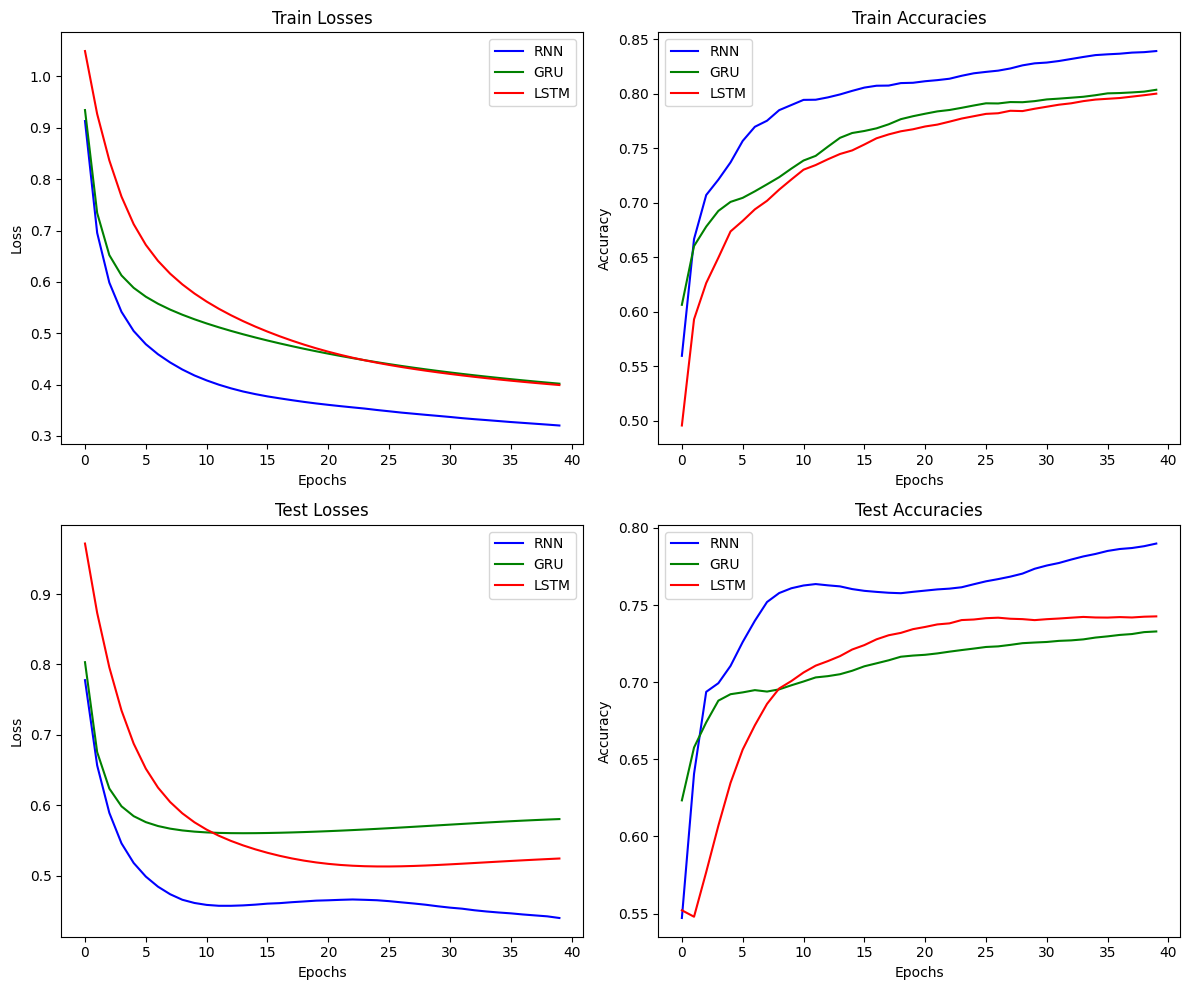


Model Comparison:
Model      Train Loss   Test Loss    Train Acc    Test Acc    
--------------------------------------------------
RNN        0.3203       0.4397       0.8394       0.7899      
GRU        0.4017       0.5803       0.8038       0.7329      
LSTM       0.3991       0.5242       0.8003       0.7427      

Best model based on test accuracy: RNN (0.7899)


In [14]:
from tqdm import tqdm

NUM_CLASSES = 3
HIDDEN_SIZE = 32
NUM_EPOCHS = 40
BATCH_SIZE = 64
TEST_SIZE = 0.8
SEQUENCE_LENGTH = 5
LEARNING_RATE = 0.01
MOMENTUM = 0.9

X_train, X_test, y_train, y_test = load_and_preprocess_data()
train_loader, test_loader = create_data_loaders(
    X_train, X_test, y_train, y_test, BATCH_SIZE, SEQUENCE_LENGTH)

model = RNN_Classifier(X_train.shape[1], NUM_CLASSES, HIDDEN_SIZE, RNN)


def train_model(model, train_loader, test_loader, model_name, num_epochs=NUM_EPOCHS):
    optimizer = SGD(model, lr=LEARNING_RATE)
    criterion = CrossEntropyLoss()

    RNN_train_losses, RNN_train_accuracies = [], []
    RNN_test_losses, RNN_test_accuracies = [], []
    for _ in tqdm(range(1, num_epochs + 1), desc=f"Training {model_name}"):
        RNN_train_loss, RNN_train_accuracy = 0.0, 0.0
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.detach().numpy()
            y_batch = y_batch.detach().numpy()
            optimizer.zero_grad()
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            model.backward(X_batch, criterion.backward(predictions, y_batch))
            optimizer.step()
            cur_accuracy = np.sum(predictions.argmax(axis=1) == y_batch)
            RNN_train_loss += loss * X_batch.shape[0]
            RNN_train_accuracy += cur_accuracy
        RNN_test_loss, RNN_test_accuracy = 0.0, 0.0
        model.eval()
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.detach().numpy()
            y_batch = y_batch.detach().numpy()
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            RNN_test_loss += loss.item() * X_batch.shape[0]
            RNN_test_accuracy += np.sum(predictions.argmax(axis=1) == y_batch)
        RNN_train_loss /= len(train_loader.dataset)
        RNN_test_loss /= len(test_loader.dataset)
        RNN_train_accuracy /= len(train_loader.dataset)
        RNN_test_accuracy /= len(test_loader.dataset)
        RNN_train_losses += [RNN_train_loss]
        RNN_train_accuracies += [RNN_train_accuracy]
        RNN_test_losses += [RNN_test_loss]
        RNN_test_accuracies += [RNN_test_accuracy]
    return {
        'train_losses': RNN_train_losses,
        'test_losses': RNN_test_losses,
        'train_accuracies': RNN_train_accuracies,
        'test_accuracies': RNN_test_accuracies
    }


def main():
    X_train, X_test, y_train, y_test = load_and_preprocess_data()

    train_loader, test_loader = create_data_loaders(
        X_train, X_test, y_train, y_test, BATCH_SIZE, SEQUENCE_LENGTH)

    models = {
        'RNN': RNN_Classifier(X_train.shape[1], NUM_CLASSES, HIDDEN_SIZE, RNN),
        'GRU': RNN_Classifier(X_train.shape[1], NUM_CLASSES, HIDDEN_SIZE, GRU),
        'LSTM': RNN_Classifier(X_train.shape[1], NUM_CLASSES, HIDDEN_SIZE, LSTM)
    }

    results = {}
    for model_name, model in models.items():
        results[model_name] = train_model(model, train_loader, test_loader, model_name, NUM_EPOCHS)

    plot_comparison(results)

    print_comparison_table(results)

    find_best_model(results)


if __name__ == "__main__":
    main()